In [4]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
from matplotlib.ticker import MultipleLocator,AutoMinorLocator
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
from matplotlib.lines import Line2D

from astropy.io import ascii
from astropy.table import Table, Column, vstack, unique
import numpy as np
import re
import matplotlib.cm as cm
import sys

ref_date = 58974.14

def import_snana(filename):
    start_data = False
    table = None
    
    with open(filename) as f:
        for i,line in enumerate(f):
            if 'VARLIST' in line:
                header = line.split()
                header = header[0:9]
                dummy = [['X'*20]]*len(header)
                table = Table(dummy, names=header).copy()[:0]
            elif table is not None:
                data=line.split()
                data=data[0:9]
                if len(data)!=9:
                    break
                table.add_row(data)
        
    mask = np.array([r['MAGERR'] is not None for r in table])
    table = table[mask]
                
    
    table['MJD']    = table['MJD'].astype(float)
    table['MAG']    = table['MAG'].astype(float)
    table['MAGERR'] = table['MAGERR'].astype(float)
    table['FLUXCALERR'] = table['MAGERR'].astype(float)
    table['FLUXCAL'] = table['MAGERR'].astype(float)
    table['MAGSYS'] = table['MAGSYS'].astype(str)

    return(table)

def ccolor(r,g,b):
    return((r/255.,g/255.,b/255., 1.0))

black=ccolor(0,0,0)
red=ccolor(255,0,0)
blue=ccolor(50,50,255)
green=ccolor(12,83,0)
magenta=ccolor(204,0,204)
goldenrod=ccolor(239,139,8)
orange=ccolor(204,102,0)

# Plotting parameters and functions
pad = 0.25
figsize = 10.0
rc('font',**{'family':'serif','serif':['Times'],'size':6.0*figsize})
rc('text', usetex=True, color=black)

def setup_plot(size=[1.8, 1.5]):

    fig, ax = plt.subplots()
    for i in ax.spines.keys(): ax.spines[i].set_linewidth(0.6*figsize)
    fig.set_size_inches(size[0]*figsize, size[1]*figsize)

    return(fig, ax)

def setup_ticks(ax):

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    ax.tick_params(direction='in', length=1.5*figsize,
            width=0.5*figsize, which='major', axis='both', colors=black,
            pad=0.3*figsize, top=True, bottom=True, left=True, right=True)
    ax.tick_params(direction='in', length=0.75*figsize,
            width=0.5*figsize, which='minor', axis='both', colors=black,
            pad=0.3*figsize, top=True, bottom=True, left=True, right=True)

def setup_axis_titles(ax, xtitle, ytitle):

        ax.set_xlabel(xtitle, labelpad=pad)
        ax.set_ylabel(ytitle, labelpad=pad)

In [5]:
header_string='# ph	T_bb	err_T_bb	R_bb	err_R_bb	L_bb	err_L_bb	T_opt	err_T_opt	R_opt	err_R_opt	L_opt	err_L_opt'
header_string=header_string.replace('#','')
names=header_string.strip().split()
table = Table.read('BB_params_2020jfo_SDAUBgVriz.txt',format='ascii', names=names)
print(table)
print(table.keys())

   ph      T_bb  err_T_bb        R_bb           err_R_bb       L_bb   err_L_bb  T_opt  err_T_opt       R_opt          err_R_opt      L_opt   err_L_opt
-------- ------- -------- ----------------- ---------------- -------- -------- ------- --------- ----------------- ---------------- -------- ---------
58975.25 11600.0    928.0 177000000000000.0 19100000000000.0 4.09e+41 1.57e+41 15100.0    3230.0 137000000000000.0 29100000000000.0 7.03e+41   6.7e+41
58976.16 11700.0    973.0 241000000000000.0 26300000000000.0 7.81e+41  3.1e+41 15000.0    3190.0 190000000000000.0 39900000000000.0 1.31e+42  1.24e+42
 58976.3 10200.0    678.0 330000000000000.0 42900000000000.0 8.51e+41 3.16e+41 11800.0    2050.0 276000000000000.0 67300000000000.0 1.05e+42  8.93e+41
58977.18  9090.0    570.0 472000000000000.0 53800000000000.0 1.09e+42 3.68e+41  9730.0    1350.0 424000000000000.0 95400000000000.0 1.15e+42  8.22e+41
58977.55  9060.0    519.0 464000000000000.0 51000000000000.0 1.03e+42 3.29e+41  9380.0    1110

In [6]:
bin_size=3
table.sort('ph')
binned_radius = []
times = np.linspace(np.min(table['ph']), np.max(table['ph']), int((np.max(table['ph'])-np.min(table['ph']))/bin_size))
for t in times:
    mask = (table['ph'] > t) & (table['ph'] < t + bin_size)
    binned_radius.append(np.mean(table[mask]['R_bb']))

binned_radius = np.array(binned_radius)
mask = ~np.isnan(binned_radius)
times = times[mask]
binned_radius = binned_radius[mask]
print(times-ref_date)
print(binned_radius)
binned_radius[16]=(binned_radius[15]+binned_radius[17])/2
binned_radius[17]=(binned_radius[16]+binned_radius[18])/2
print(binned_radius[16])
print(binned_radius)

from scipy.interpolate import interp1d

f = interp1d(times, binned_radius)

[  1.11         4.13704348   7.16408696  10.19113043  13.21817391
  16.24521739  19.27226087  22.29930435  25.32634783  28.3533913
  31.38043478  34.40747826  37.43452174  40.46156522  43.4886087
  46.51565217  49.54269565  52.56973913  55.59678261  58.62382609
  61.65086957  67.70495652  73.75904348  85.86721739 194.84078261
 200.89486957 203.92191304 213.00304348 219.05713043 222.08417391
 228.13826087 234.19234783 240.24643478 246.30052174 249.32756522
 252.3546087  255.38165217 261.43573913 267.48982609 270.51686957
 273.54391304 279.598      282.62504348 285.65208696 291.70617391
 318.94956522 340.13886957 343.16591304]
[4.37285714e+14 6.66285714e+14 8.05200000e+14 1.00585714e+15
 1.37500000e+15 1.63000000e+15 1.90200000e+15 1.71000000e+15
 2.00250000e+15 2.05200000e+15 2.26500000e+15 2.47000000e+15
 2.65333333e+15 2.80000000e+15 2.61666667e+15 2.61666667e+15
 3.09000000e+15 2.55500000e+15 2.74000000e+15 2.44250000e+15
 2.50250000e+15 3.15000000e+15 2.08500000e+15 1.26000000e+15
 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


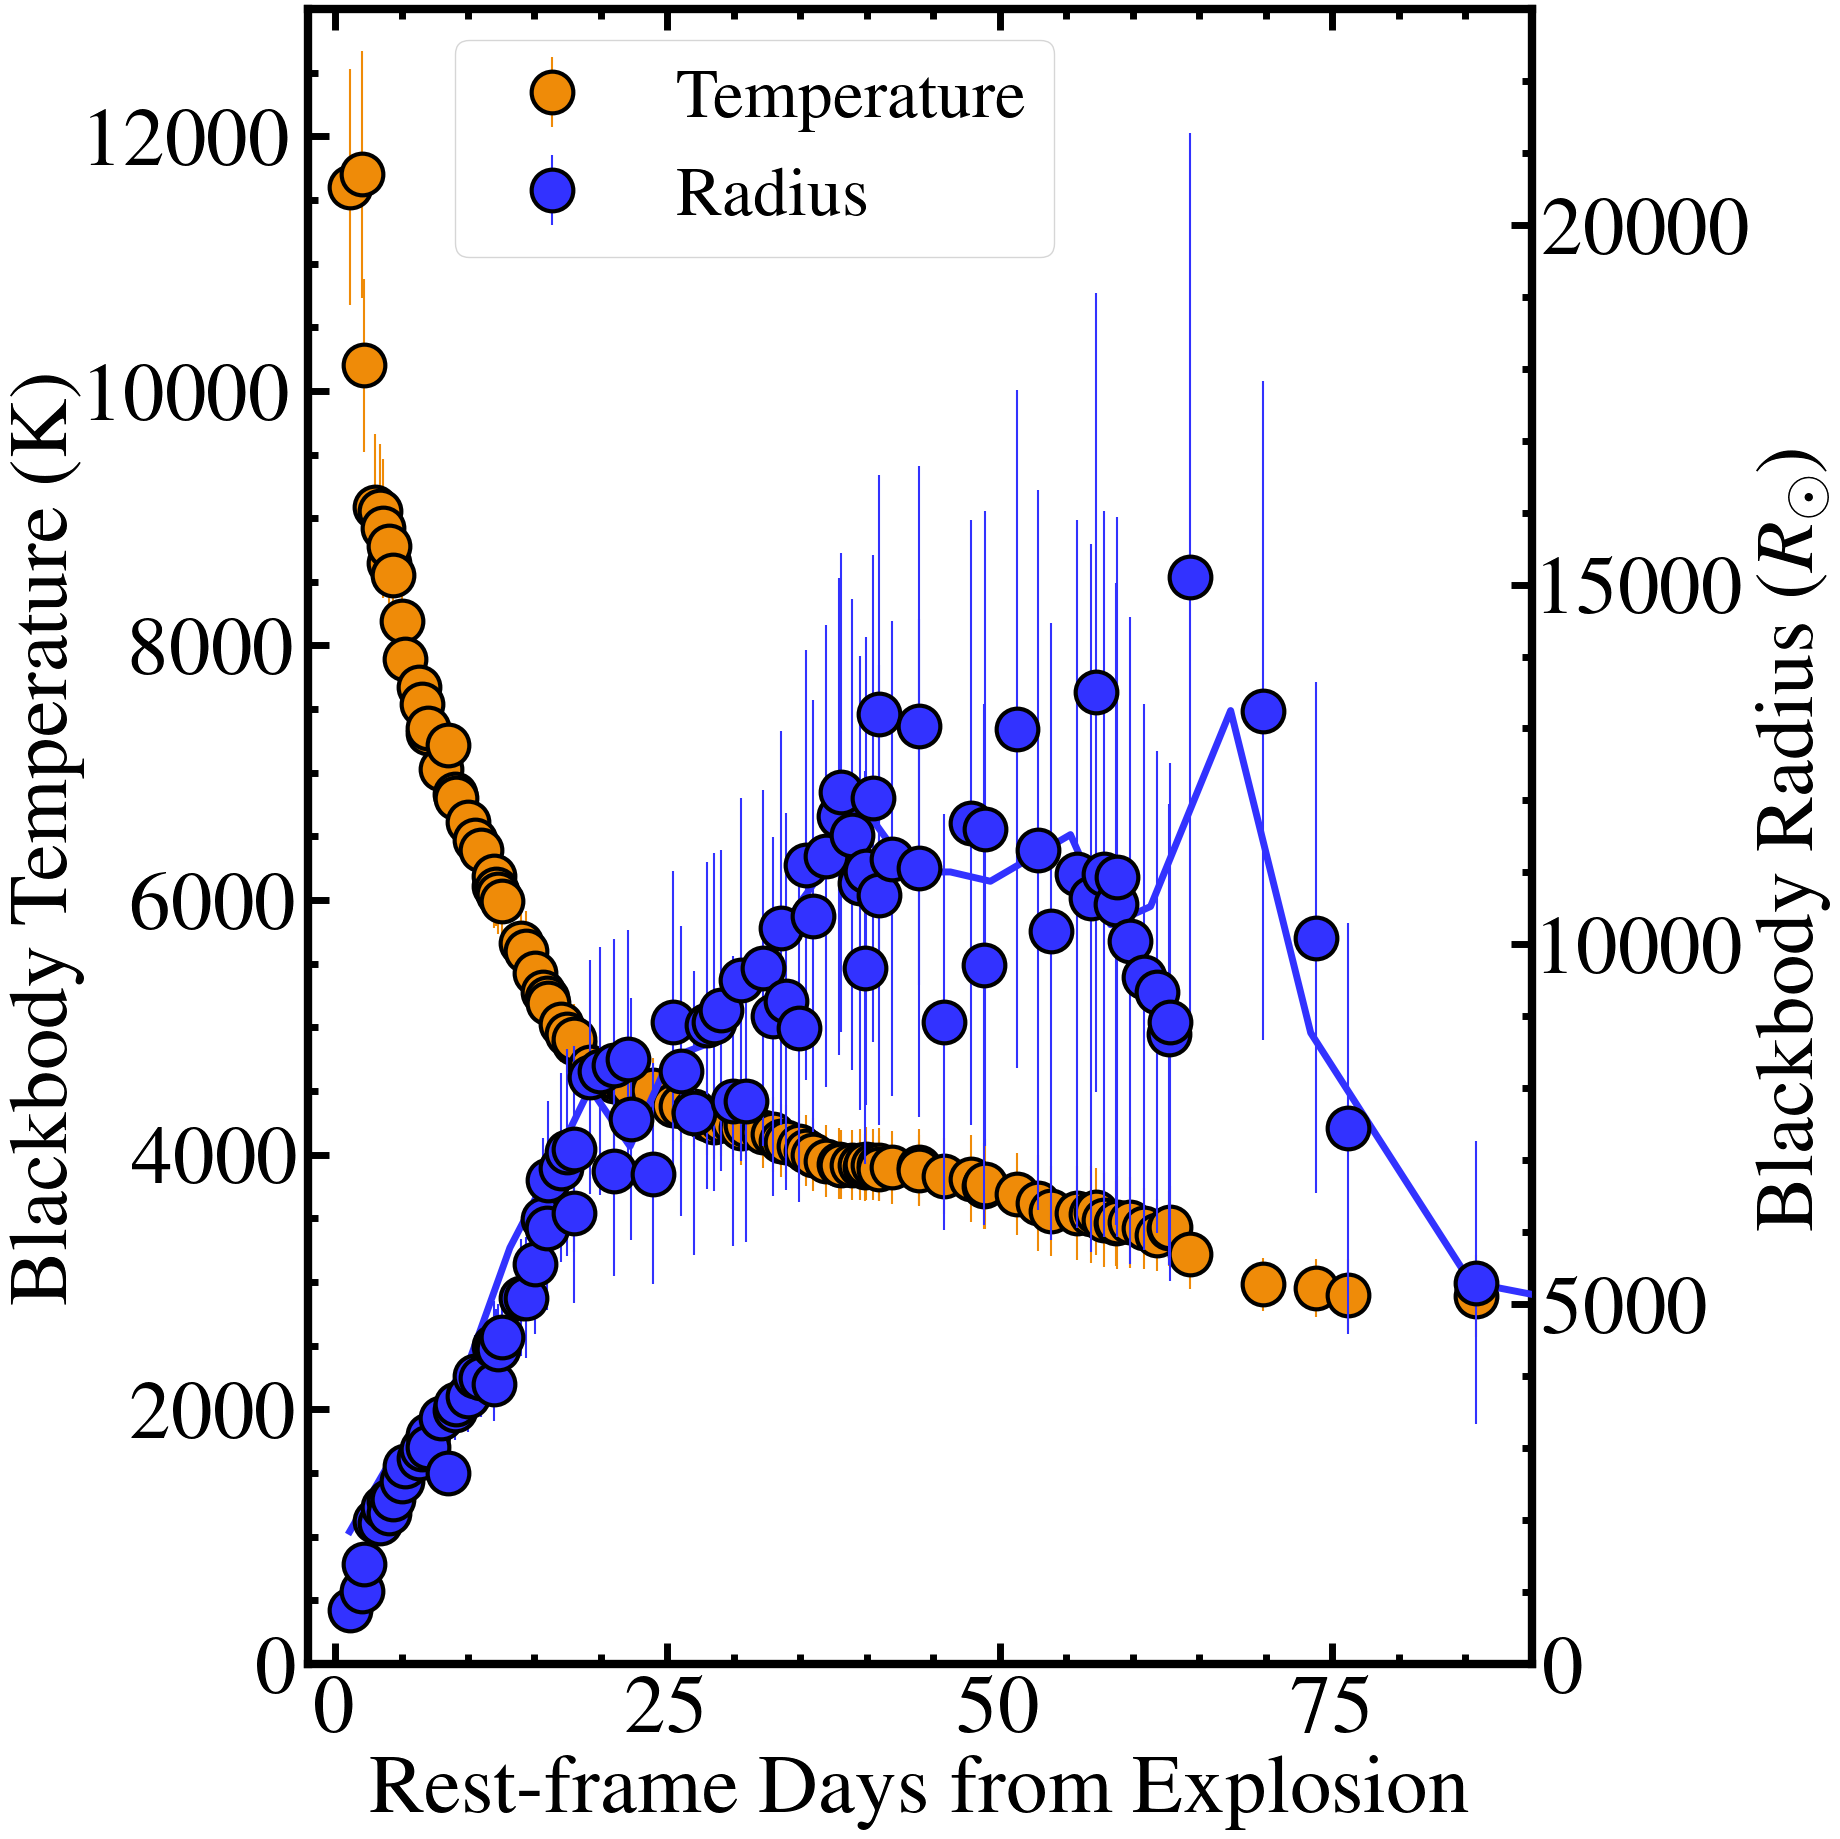

In [7]:
from astropy.time import Time
import copy
from matplotlib.legend_handler import HandlerTuple
from matplotlib.container import ErrorbarContainer

def setup_ticks(ax):

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    ax.tick_params(direction='in', length=1.5*figsize,
            width=0.5*figsize, which='major', axis='both', colors=black,
            pad=0.8*figsize, top=True, bottom=True, left=True, right=True)
    ax.tick_params(direction='in', length=0.75*figsize,
            width=0.5*figsize, which='minor', axis='both', colors=black,
            pad=0.8*figsize, top=True, bottom=True, left=True, right=True)

# Set up periodogram plot parameters
rc('font',**{'family':'serif','serif':['Times'],'size':6.0*figsize})
rc('text', usetex=True, color=black)
fig, ax = setup_plot(size=[2.0, 2.0])

#ref_date = Time('2020-05-06 04:51:41.184').mjd
ref_date = 58974.14
z=0.00502

setup_ticks(ax)

par1 = ax.twinx()

par1.xaxis.set_minor_locator(AutoMinorLocator())
par1.yaxis.set_minor_locator(AutoMinorLocator())

par1.tick_params(direction='in', length=1.5*figsize,
            width=0.5*figsize, which='major', axis='both', colors=black,
            pad=0.8*figsize, top=True, bottom=True, left=False, right=True)
par1.tick_params(direction='in', length=0.75*figsize,
            width=0.5*figsize, which='minor', axis='both', colors=black,
            pad=0.8*figsize, top=True, bottom=True, left=False, right=True)

ax.set_ylabel('Blackbody Temperature (K)')
par1.set_ylabel(r'Blackbody Radius ($R_{\odot}$)')

ax.set_xlabel('Rest-frame Days from Explosion')

scale = np.max(table['T_opt'])/np.max(table['R_opt'])

ms=3*figsize

p1=ax.errorbar((table['ph']-ref_date)/(1.+z), table['T_bb'], yerr=table['err_T_bb'],fmt='o',ms=ms,
            mec=black, color=goldenrod, mew=0.3*figsize, label='Temperature')
p2=par1.errorbar((table['ph']-ref_date)/(1.+z), table['R_bb']*scale, yerr=table['err_R_bb']*scale,fmt='o',ms=ms,
            mec=black, color=blue, mew=0.3*figsize, label='Radius')
p3=par1.plot((times-ref_date)/(1.+z), binned_radius*scale, linewidth=0.5*figsize, color=blue)
plt.legend(handles=[p1,p2],loc=[0.12,0.85], fontsize=5.0*figsize)

ax.set_xlim([-2,90])
ax.set_ylim([0,13000])
par1.set_ylim([0,23000])

plt.tight_layout()

plt.savefig('2020jfo-bb.eps', format='eps')
plt.show()

In [8]:
import emcee, copy
import numpy as np
from astropy.table import Table,Column
import matplotlib.pyplot as plt

plt.clf()

# Input parameters - superbol file and MJD explosion/discovery date
data_file='logL_obs_2020jfo_SDAUBgVriz.txt'
mjd_start=58974.14
z=0.00502

def valenti_model(time, theta):
    a, tpt, w, p, m = theta
    return(-a/(1. + np.exp((time-tpt)/w))+p*time+m)

def valenti_modified_model(time, theta):
    a, tpt, w, p, m, t1 = theta
    return(-a/(1. + np.exp((time-tpt)/w))+p*time+m)

def lnlikelihood(theta, lum, dlum, time):
    model_lum = valenti_model(time, theta)
    
    # Set parameter range value
    a, tpt, w, p, m = theta
    if a<0.01: return(-np.inf)
    if a>10.0: return(-np.inf)
    if tpt<10.0: return(-np.inf)
    if w<0.01: return(-np.inf)
    
    inv_sigma = 1./dlum**2
    return(-0.5 * np.sum((lum-model_lum)**2 * inv_sigma))

def load_table(data_file, mjd_start=mjd_start, mask_date=15.0, z=z):
    # The code will automatically mask data mask_date days from the input reference date.
    # Change this value in order to adjust the amount of data that's included/excluded
    
    table = Table.read(data_file, format='ascii',names=('MJD','lum','dlum'))
    
    # Want to fit versus a magnitude rather than actual luminosity, so convert lum to Mbol
    # Here 83.9605452803 = 2.5*log10(3.839e33) for Solar luminosity
    # 4.74 is bolometric luminosity of the Sun
    Mbol = -2.5*table['lum'] + 83.9605452803 + 4.74
    Mbolerr = table['dlum']
    
    table.add_column(Column(Mbol, name='Mbol'))
    table.add_column(Column(Mbolerr, name='Mbolerr'))
    
    newcol=Column((table['MJD'].data-mjd_start)/(1+z),name='t_exp')
    table.add_column(newcol)
    
    mask = table['t_exp']>mask_date
    table=table[mask]
    
    return(table)

def mcmc_valenti(data_file, ndim=5, nwalkers=100, inflate_errors=0.1):
    
    # I'm adding a parameter to inflate the error bars because the code appears to underfit the
    # late time decline due to nickel, which is primarily what we're interested in
    
    params = [2.0, 70, 2.5, 0.0420, -18.0]
    pos = [params + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
    
    table = load_table(data_file)
    table['Mbolerr'] = np.sqrt(table['Mbolerr']**2+inflate_errors**2)
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlikelihood, 
                                    args=(table['Mbol'],
                                          table['Mbolerr'],
                                          table['t_exp']))
    
    sampler.run_mcmc(pos, 500, progress=True)
    samples = sampler.chain[:, 99:, :].reshape((-1, ndim))
    
    return(samples)

def get_param_uncertainties(samples):
    
    vals = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                 zip(*np.percentile(samples, [16, 50, 84],
                                                    axis=0)))
    
    vals = [v for v in vals]
    
    return(vals)

def setup_ticks(ax):

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    ax.tick_params(direction='in', length=1.5*figsize,
            width=0.5*figsize, which='major', axis='both', colors=black,
            pad=0.8*figsize, top=True, bottom=True, left=True, right=True)
    ax.tick_params(direction='in', length=0.75*figsize,
            width=0.5*figsize, which='minor', axis='both', colors=black,
            pad=0.8*figsize, top=True, bottom=True, left=True, right=True)
    
    
def setup_axis_titles(ax, xtitle, ytitle):

        ax.set_xlabel(xtitle, labelpad=pad)
        ax.set_ylabel(ytitle, labelpad=pad)
    
    
    
samples=mcmc_valenti(data_file)
params=get_param_uncertainties(samples)

print('Best-fit parameters:')
for p in copy.copy(params):
    print('Param: {0} + {1} - {2}'.format(p[0], p[1], p[2]))

best_fit=[p[0] for p in copy.copy(params)]

  7%|████████████                                                                                                                                                                 | 35/500 [00:00<00:04, 110.52it/s]/var/folders/_s/tc8h43192s58wb4s6m2lbfcw0000gn/T/ipykernel_5590/1334620118.py:15: RuntimeWarning: overflow encountered in exp
  return(-a/(1. + np.exp((time-tpt)/w))+p*time+m)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:04<00:00, 111.45it/s]

Best-fit parameters:
Param: 1.2844041451336836 + 0.1346151627619918 - 0.10036977295904759
Param: 65.33199037795282 + 1.4706259585107802 - 0.8955911811567177
Param: 3.844305495295429 + 0.8859514099460215 - 0.7402609308480246
Param: 0.01263683889042293 + 0.0005524329116119997 - 0.000645315779971501
Param: -14.400945529506817 + 0.1476343728337035 - 0.11397503672132459


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

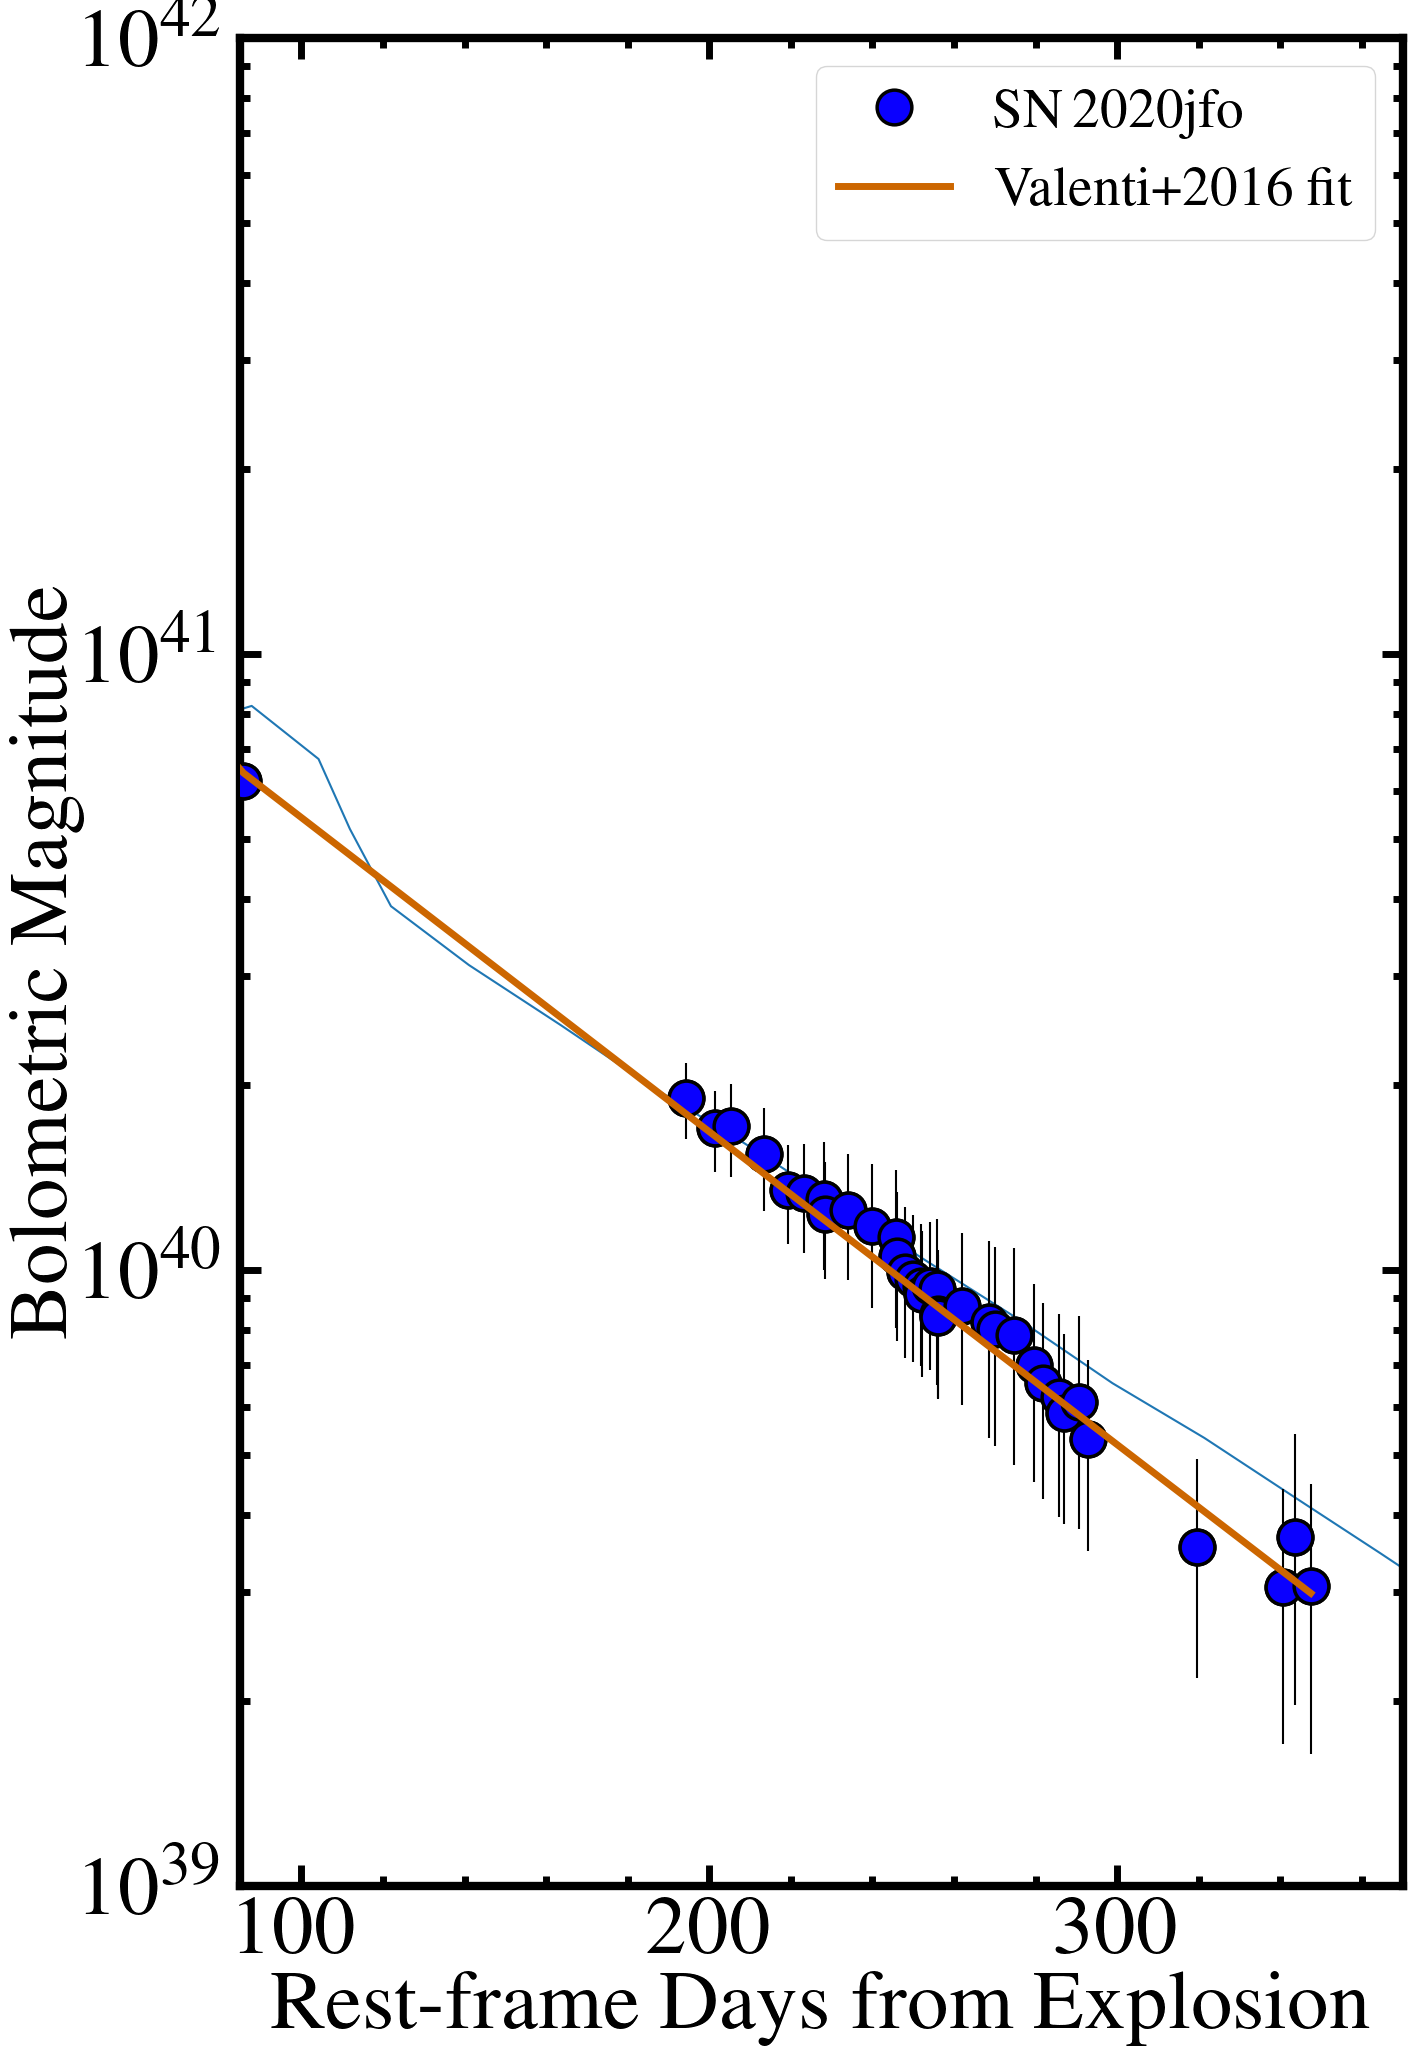

In [16]:
# Set up periodogram plot parameters
plt.clf()
rc('font',**{'family':'serif','serif':['Times'],'size':6.0*figsize})
rc('text', usetex=True, color=black)
fig, ax = setup_plot(size=[1.5, 2.4])

model_uncertainty=False

def ccolor(r,g,b):
    return((r/255.,g/255.,b/255., 1.0))

sdata = Table.read('2020jfo_sollerman.txt', format='csv', names=('mjd','loglum'))
sn1987adata = Table.read('1987A.txt', format='csv', names=('epoch','loglum'))

black=ccolor(0,0,0)
red=ccolor(255,0,0)
blue=ccolor(10,0,255)
green=ccolor(12,83,0)
magenta=ccolor(204,0,204)
goldenrod=ccolor(239,139,8)
orange=ccolor(204,102,0)
light_orange=ccolor(240,150,0)

#ref_date = Time('2020-05-06 04:51:41.184').mjd
ref_date = 58974.14
z=0.00502

setup_ticks(ax)
setup_axis_titles(ax,'Rest-frame Days from Explosion', 'Bolometric Magnitude')

table = load_table(data_file)
tab_lum = 3.839e33 * 10**(-0.4*(table['Mbol']-4.74))
tab_lum_err = tab_lum * table['Mbolerr']/1.086
for i,row in enumerate(table):
    if i==0:
        label=r'SN\,2020jfo'
    else:
        label=None
    ax.plot((row['MJD']-mjd_start)/(1+z), tab_lum[i], 'o', ms=2.5*figsize, markeredgewidth=0.25*figsize,
           color=blue, markeredgecolor=black, label=label)
    ax.errorbar((row['MJD']-mjd_start)/(1+z), tab_lum[i], yerr=tab_lum_err[i], 
                marker='o', zorder=5, ms=2.5*figsize, markeredgewidth=0.25*figsize, 
                markeredgecolor=black, color=blue,
                ecolor=black, linestyle=None)
    
model_lum=valenti_model(table['MJD']-mjd_start, best_fit)

plot_lum = 3.839e33 * 10**(-0.4*(model_lum-4.74))

ax.plot((table['MJD']-mjd_start)/(1+z), plot_lum, zorder=10, 
        linewidth=0.5*figsize, color=orange, label='Valenti+2016 fit')

ax.plot(sn1987adata['epoch'], 10**sn1987adata['loglum']*0.11)

#ax.plot(sdata['mjd'], 10**sdata['loglum'], marker='*')

if model_uncertainty:
    
    all_lum = np.zeros((len(samples[100:]), len(table)))
    for i,s in enumerate(samples[100:]):
        all_lum[i,:]=valenti_model(table['MJD']-mjd_start, s)

    max_lum = np.array([np.max(all_lum[:,j]) for j in np.arange(len(table))])
    min_lum = np.array([np.min(all_lum[:,j]) for j in np.arange(len(table))])

    max_lum = 3.839e33 * 10**(-0.4 * (max_lum-4.74))
    min_lum = 3.839e33 * 10**(-0.4 * (min_lum-4.74))

    ax.fill_between((table['MJD']-mjd_start)/(1+z), max_lum, min_lum, zorder=0, color=light_orange)

ax.set_ylim([1.0e39,1.0e42])
ax.set_xlim([85,370])
ax.set_yscale('log')

plt.legend(fontsize=4.0*figsize, loc='upper right')

plt.show()

0.009111718076591264 263.9949900569267
7.791465648021927e-05
3.4915899106167094
[[ 2.40163988e+58 -3.72656273e+29]
 [-3.72656273e+29  1.21912001e+01]]
Total mass of Ni-56 scaled from SN1987A is: 0.009111718076591264


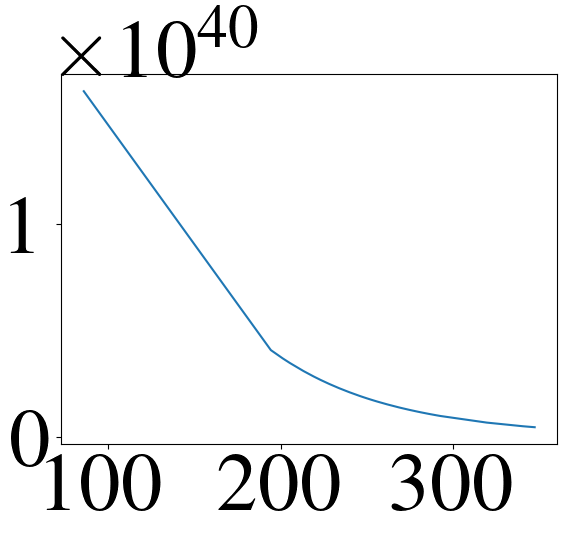

In [42]:
import scipy
from scipy.optimize import curve_fit
sn1987a_func=scipy.interpolate.interp1d(sn1987adata['epoch'], 10**sn1987adata['loglum'])
def sn1987a(x, a):
    return(sn1987a_func(x)*a)

def ni56_modified(x, m, t1):
    epsilon = 6.8e9
    lambda_Co56 = np.log(2)/77.233
    lambda_Ni56 = np.log(2)/6.075
    
    lambda_par = (lambda_Co56 - lambda_Ni56)/lambda_Ni56
    
    gamma = (1-0.965*np.exp(-(t1/x)**2))
    
    lc = (np.exp(-lambda_Ni56*x) - np.exp(-lambda_Co56*x))
    
    lum = m*epsilon * 1./lambda_par * lc * gamma
    
    return(lum)
    
    
    
    

mask = (table['MJD']-mjd_start)/(1+z)>85

popt, pcov = curve_fit(ni56_modified, (table['MJD'][mask]-mjd_start)/(1+z), tab_lum[mask],
                      p0=(0.018*1.989e33,100))
print(popt[0]/1.989e33,popt[1])
print(np.sqrt(pcov[0][0])/1.989e33)
print(np.sqrt(pcov[1][1]))
print(pcov)

#plt.plot((table['MJD'][mask]-mjd_start)/(1+z), tab_lum[mask])
plt.plot((table['MJD'][mask]-mjd_start)/(1+z),
    ni56_modified((table['MJD'][mask]-mjd_start)/(1+z), 2.4e-3*1.989e33, 200))

# From equation 1 in Valenti+2016
print('Total mass of Ni-56 scaled from SN1987A is:',popt[0]/1.989e33)

In [14]:
from __future__ import print_function

luminosity=[]
mass_Ni56=[]
# Using 270.0 rest-frame days as reference time
for kk in np.arange(35):
    print(kk)
    lightcurve_ref_time = 195+kk*5.0
    for s in samples:
        abs_mag=valenti_model(lightcurve_ref_time, s)
        luminosity.append(3.839e33 * 10**(-0.4 * (abs_mag-4.74)))

    data = np.percentile(luminosity, [16, 50, 84])
    lum=data[1]
    errhi=data[2]-data[1]
    errlo=data[1]-data[0]
    print(lightcurve_ref_time)
    print('Luminosity (1e39 erg/s)=','%1.2f'%(lum*1.0e-39),'+','%1.2f'%(errhi*1.0e-39),'-','%1.2f'%(errlo*1.0e-39))

    # Heating rate for Co-56 decay in erg/s/g
    epsilon = 6.8e9
    # Mass of Co-56 in grams at 270 days
    mass_Co56 = np.array(luminosity) / epsilon

    # Radioactive decay timescale for Ni-56 and Co-56.  These are equal to ln(2)/(half-life)
    # Half-life for Ni-56 is 6.075 days, Half-life for Co-56 is 55.93983 days
    lambda_Co56 = np.log(2)/77.233
    lambda_Ni56 = np.log(2)/6.075

    # Mass of Ni-56 at t=0
    init_mass_Ni56=mass_Co56 * (lambda_Co56 - lambda_Ni56)/lambda_Ni56 * (np.exp(-lambda_Ni56 * lightcurve_ref_time) - np.exp(-lambda_Co56 * lightcurve_ref_time))**-1
    print(np.mean(init_mass_Ni56/(1.989e33))*1.0e3)
    mass_Ni56.extend(init_mass_Ni56)
data = np.percentile(mass_Ni56, [16, 50, 84])
mass=data[1]
errhi=data[2]-data[1]
errlo=data[1]-data[0]
print('Mass (Msun)=','%1.4f'%(mass/(1.989e33)),'+','%1.4f'%(errhi/(1.989e33)),'-','%1.4f'%(errlo/(1.989e33)))

0
195.0
Luminosity (1e39 erg/s)= 17.91 + 0.77 - 0.78
7.012186783186327
1
200.0
Luminosity (1e39 erg/s)= 17.38 + 0.93 - 0.91
7.127606056921144
2
205.0
Luminosity (1e39 erg/s)= 16.87 + 1.18 - 1.10
7.246970418478716
3
210.0
Luminosity (1e39 erg/s)= 16.38 + 1.45 - 1.31
7.370411280398108
4
215.0
Luminosity (1e39 erg/s)= 15.91 + 1.73 - 1.53
7.498064931642788
5
220.0
Luminosity (1e39 erg/s)= 15.46 + 1.99 - 1.74
7.630072723344567
6
225.0
Luminosity (1e39 erg/s)= 15.02 + 2.25 - 1.94
7.766581261913481
7
230.0
Luminosity (1e39 erg/s)= 14.59 + 2.51 - 2.13
7.907742609788836
8
235.0
Luminosity (1e39 erg/s)= 14.17 + 2.76 - 2.30
8.05371449412623
9
240.0
Luminosity (1e39 erg/s)= 13.78 + 3.00 - 2.47
8.204660523732256
10
245.0
Luminosity (1e39 erg/s)= 13.38 + 3.24 - 2.60
8.360750414574373
11
250.0
Luminosity (1e39 erg/s)= 13.00 + 3.46 - 2.73
8.522160224208367
12
255.0
Luminosity (1e39 erg/s)= 12.63 + 3.68 - 2.84
8.68907259548102
13
260.0
Luminosity (1e39 erg/s)= 12.27 + 3.88 - 2.95
8.861677009880763
14
2

In [ ]:
def ni56_modified(x, m, t1):
    epsilon = 6.8e9
    lambda_Co56 = np.log(2)/77.233
    lambda_Ni56 = np.log(2)/6.075
    
    lambda_par = (lambda_Co56 - lambda_Ni56)/lambda_Ni56
    
    gamma = (1-0.965*np.exp(-(t1/x)**2))
    
    lc = (np.exp(-lambda_Ni56*x) - np.exp(-lambda_Co56*x))
    
    lum = m*epsilon * 1./lambda_par * lc * gamma
    
    return(lum)
  
def ni56(m, t1):
    epsilon = 6.8e9
    lambda_Co56 = np.log(2)/77.233
    lambda_Ni56 = np.log(2)/6.075
    
    lambda_par = (lambda_Co56 - lambda_Ni56)/lambda_Ni56
        
    lc = (np.exp(-lambda_Ni56*x) - np.exp(-lambda_Co56*x))
    
    lum = m*epsilon * 1./lambda_par * lc
    
    return(lum)